# [keras-yolo3](https://github.com/qqwweee/keras-yolo3)

### 1. Download YOLOv3 weight from [YOLO website](http://pjreddie.com/darknet/yolo/)

### 2. Convert the Darknet YOLO model to a Keras model
- Need below three file to convert
 - convert.py, yolov3.cfg (exists in keras-yolo3)
 - yolov3.weights (downloaded)

In [1]:
!python convert.py yolov3-tiny.cfg yolov3-tiny.weights model_data/yolo_tiny.h5

Loading weights.
Weights Header:  0 2 0 [32013312]
Parsing Darknet config.
Creating Keras model.
Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 16)
Parsing section maxpool_0
Parsing section convolutional_1
conv2d bn leaky (3, 3, 16, 32)
Parsing section maxpool_1
Parsing section convolutional_2
conv2d bn leaky (3, 3, 32, 64)
Parsing section maxpool_2
Parsing section convolutional_3
conv2d bn leaky (3, 3, 64, 128)
Parsing section maxpool_3
Parsing section convolutional_4
conv2d bn leaky (3, 3, 128, 256)
Parsing section maxpool_4
Parsing section convolutional_5
conv2d bn leaky (3, 3, 256, 512)
Parsing section maxpool_5
Parsing section convolutional_6
conv2d bn leaky (3, 3, 512, 1024)
Parsing section convolutional_7
conv2d bn leaky (1, 1, 1024, 256)
Parsing section convolutional_8
conv2d bn leaky (3, 3, 256, 512)
Parsing section convolutional_9
conv2d    linear (1, 1, 512, 255)
Parsing section yolo_0
Parsing section route_0
Parsing section convolutional_10


2021-11-08 17:38:28.091630: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'cudart64_100.dll'; dlerror: cudart64_100.dll not found
2021-11-08 17:38:28.092841: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Using TensorFlow backend.






2021-11-08 17:38:32.508936: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2
2021-11-08 17:38:32.511968: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2021-11-08 17:38:32.511988: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-08 17:38:32.522838: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: DESKTOP-2BVAFLS
2021-11-08 17:38:

__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 1 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, None, None, 1 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, None, None, 1 0           leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 3 4608        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, None, None, 3 128         conv2d_2[0][0]                   
__________

### 3. Object detection

In [1]:
from IPython.display import display 
from PIL import Image
from yolo import YOLO

def objectDetection(file, model_path, class_path):
    yolo = YOLO(model_path=model_path, classes_path=class_path, anchors_path="model_data/yolo_tiny_anchors.txt")

    # 이미지 로딩
    image = Image.open(file)
    model = yolo.get_model()
    model.summary()

    # 실행
    result_image = yolo.detect_image(image)

    # 실행 결과 표시
    display(result_image)

Using TensorFlow backend.


In [2]:
objectDetection('data/money/images_test/IMG_3083.JPG', 'model_data/yolo_tiny.h5', 'model_data/coco_classes.txt')





num_anchors 6
num_classes 80









model_data/yolo_tiny.h5 model, anchors, and classes loaded.
self.yolo_model.output [<tf.Tensor 'conv2d_10/BiasAdd:0' shape=(?, ?, ?, 255) dtype=float32>, <tf.Tensor 'conv2d_13/BiasAdd:0' shape=(?, ?, ?, 255) dtype=float32>]
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


FileNotFoundError: [Errno 2] No such file or directory: 'data/light/images_test/IMG_3083.JPG'

# YOLO Custom data training

### 1. Convert VOC dataset to YOLO annotation
- copy and modified from voc_annotation.py

In [4]:
# Get class list
def load_classes():
    with open('./data/money/classes.txt') as f:
        classes = f.read().splitlines()
    return classes

classes = load_classes()
print(classes)

['bulb']


In [5]:
# Get annotations_voc list
import glob

annotations_voc = glob.glob('./data/money/annotations_voc/*.xml')
print(annotations_voc)

['./data/light/annotations_voc\\IMG_3066.xml', './data/light/annotations_voc\\IMG_3067.xml', './data/light/annotations_voc\\IMG_3068.xml', './data/light/annotations_voc\\IMG_3069.xml', './data/light/annotations_voc\\IMG_3070.xml', './data/light/annotations_voc\\IMG_3071.xml', './data/light/annotations_voc\\IMG_3072.xml', './data/light/annotations_voc\\IMG_3073.xml', './data/light/annotations_voc\\IMG_3074.xml', './data/light/annotations_voc\\IMG_3075.xml', './data/light/annotations_voc\\IMG_3076.xml', './data/light/annotations_voc\\IMG_3077.xml', './data/light/annotations_voc\\IMG_3078.xml', './data/light/annotations_voc\\IMG_3079.xml', './data/light/annotations_voc\\IMG_3080.xml', './data/light/annotations_voc\\IMG_3081.xml', './data/light/annotations_voc\\IMG_3082.xml']


In [6]:
import xml.etree.ElementTree as ET
from os import getcwd

def convert_annotation(annotation_voc, converted_file):
    tree = ET.parse(annotation_voc)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        converted_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

converted_file = open('./data/money/annotations_yolo/train_all.txt', 'w')
for annotation_voc in annotations_voc:
    image_id = annotation_voc.split('/')[-1].split('.')[0].split('\\')[1] +'.JPG'
    converted_file.write('./data/money/images_train/%s'%(image_id))
    convert_annotation(annotation_voc, converted_file)
    converted_file.write('\n')
converted_file.close()

### 2. Retrain the YOLO model for custom dataset
- copy and modified from train.py

In [7]:
"""
Retrain the YOLO model for your own dataset.
"""

import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data


def _main():
    annotation_path = 'data/money/annotations_yolo/train_all.txt'
    log_dir = 'logs/001/'
    classes_path = 'data/money/classes.txt'
    anchors_path = 'model_data/yolo_tiny_anchors.txt'
    class_names = get_classes(classes_path)
    num_classes = len(class_names)
    anchors = get_anchors(anchors_path)

    input_shape = (416,416) # multiple of 32, hw

    is_tiny_version = len(anchors)==6 # default setting
    if is_tiny_version:
        model = create_tiny_model(input_shape,
                                  anchors,
                                  num_classes,
                                  freeze_body=2,
                                  weights_path='model_data/yolo_tiny.h5')
    else:
        model = create_model(input_shape,
                             anchors,
                             num_classes,
                             freeze_body=2,
                             weights_path='model_data/yolo_tiny.h5')

    logging = TensorBoard(log_dir=log_dir)
    checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
        monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

    val_split = 0.1
    with open(annotation_path) as f:
        lines = f.readlines()
    np.random.seed(10101)
    np.random.shuffle(lines)
    np.random.seed(None)
    num_val = int(len(lines)*val_split)
    num_train = len(lines) - num_val

    # Train with frozen layers first, to get a stable loss.
    # Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
    if True:
        model.compile(optimizer=Adam(lr=1e-3), loss={
            # use custom yolo_loss Lambda layer.
            'yolo_loss': lambda y_true, y_pred: y_pred})

        batch_size = 32
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
                steps_per_epoch=max(1, num_train//batch_size),
                validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
                validation_steps=max(1, num_val//batch_size),
                epochs=50,
                initial_epoch=0,
                callbacks=[logging, checkpoint])
        model.save_weights(log_dir + 'trained_weights_stage_1.h5')

    # Unfreeze and continue training, to fine-tune.
    # Train longer if the result is not good.
    if True:
        for i in range(len(model.layers)):
            model.layers[i].trainable = True
        model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
        print('Unfreeze all of the layers.')

        batch_size = 32 # note that more GPU memory is required after unfreezing the body
        print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
        model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=100,
            initial_epoch=50,
            callbacks=[logging, checkpoint, reduce_lr, early_stopping])
        model.save_weights(log_dir + 'trained_tiny_weights_final.h5')

    # Further training if needed.


def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)


def create_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/yolo_weights.h5'):
    '''create the training model'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

def create_tiny_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/tiny_yolo_weights.h5'):
    '''create the training model, for Tiny YOLOv3'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16}[l], w//{0:32, 1:16}[l], \
        num_anchors//2, num_classes+5)) for l in range(2)]

    model_body = tiny_yolo_body(image_input, num_anchors//2, num_classes)
    print('Create Tiny YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze the darknet body or freeze all but 2 output layers.
            num = (20, len(model_body.layers)-2)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.7})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)

if __name__ == '__main__':
    _main()


Create Tiny YOLOv3 model with 6 anchors and 1 classes.


C:\Users\USER\anaconda3\envs\yolo\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_10 due to mismatch in shape ((1, 1, 512, 18) vs (255, 512, 1, 1)).
  weight_values[i].shape))
C:\Users\USER\anaconda3\envs\yolo\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_10 due to mismatch in shape ((18,) vs (255,)).
  weight_values[i].shape))
C:\Users\USER\anaconda3\envs\yolo\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_13 due to mismatch in shape ((1, 1, 256, 18) vs (255, 256, 1, 1)).
  weight_values[i].shape))
C:\Users\USER\anaconda3\envs\yolo\lib\site-packages\keras\engine\saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_13 due to mismatch in shape ((18,) vs (255,)).
  weight_values[i].shape))


Load weights model_data/yolo_tiny.h5.
Freeze the first 42 layers of total 44 layers.


Train on 16 samples, val on 1 samples, with batch size 32.




Epoch 1/50
1/1 [==============================] - 14s 14s/step - loss: 1919.5277 - val_loss: 1948.0081

Epoch 2/50
1/1 [==============================] - 12s 12s/step - loss: 1737.1166 - val_loss: 1761.4991
Epoch 3/50
1/1 [==============================] - 11s 11s/step - loss: 1572.8905 - val_loss: 1616.3829
Epoch 4/50
1/1 [==============================] - 12s 12s/step - loss: 1413.9371 - val_loss: 1383.6373
Epoch 5/50
1/1 [==============================] - 12s 12s/step - loss: 1266.7892 - val_loss: 1328.5657
Epoch 6/50
1/1 [==============================] - 12s 12s/step - loss: 1145.6000 - val_loss: 1175.1780
Epoch 7/50
1/1 [==============================] - 12s 12s/step - loss: 1028.5900 - val_loss: 1025.5320
Epoch 8/50
1/1 [==============================] - 12s 12s/step - loss: 924.1154 - val_loss: 930.0287
Epoch 9/50
1/1 [===========

Epoch 67/100
1/1 [==============================] - 16s 16s/step - loss: 35.0176 - val_loss: 40.1346
Epoch 68/100
1/1 [==============================] - 16s 16s/step - loss: 33.4455 - val_loss: 37.9480
Epoch 69/100
1/1 [==============================] - 17s 17s/step - loss: 32.1652 - val_loss: 38.7555
Epoch 70/100
1/1 [==============================] - 16s 16s/step - loss: 31.8875 - val_loss: 38.1631
Epoch 71/100
1/1 [==============================] - 16s 16s/step - loss: 30.4294 - val_loss: 36.8381
Epoch 72/100
1/1 [==============================] - 16s 16s/step - loss: 31.2798 - val_loss: 36.0627
Epoch 73/100
1/1 [==============================] - 16s 16s/step - loss: 30.9253 - val_loss: 36.7325
Epoch 74/100
1/1 [==============================] - 16s 16s/step - loss: 28.8930 - val_loss: 34.5224
Epoch 75/100
1/1 [==============================] - 16s 16s/step - loss: 28.8033 - val_loss: 36.8075
Epoch 76/100
1/1 [==============================] - 16s 16s/step - loss: 29.5473 - val_loss

In [11]:
def model_save(file, model_path, class_path):
    yolo = YOLO(model_path=model_path, classes_path=class_path, anchors_path='model_data/yolo_tiny_anchors.txt')
    model = yolo.get_model()
    model.save("yolo.h5")

In [12]:
model_save('data/light/36.jpg', 'logs/001/trained_tiny_weights_final.h5', 'data/light/classes.txt')

num_anchors 6
num_classes 1
logs/001/trained_tiny_weights_final.h5 model, anchors, and classes loaded.
self.yolo_model.output [<tf.Tensor 'conv2d_36/BiasAdd:0' shape=(?, 13, 13, 18) dtype=float32>, <tf.Tensor 'conv2d_39/BiasAdd:0' shape=(?, 26, 26, 18) dtype=float32>]


### 3. Test

In [7]:
from IPython.display import display 
from PIL import Image
from yolo import YOLO

def objectDetection(file, model_path, class_path):
    yolo = YOLO(model_path=model_path, classes_path=class_path, anchors_path='model_data/yolo_tiny_anchors.txt')
    model = yolo.get_model()

    # 이미지 로딩
    image = Image.open(file)

    # 실행
    result_image = yolo.detect_image(image)

    # 실행 결과 표시
    display(result_image)

num_anchors 6
num_classes 4
logs/001/trained_tiny_weights_final.h5 model, anchors, and classes loaded.
self.yolo_model.output [<tf.Tensor 'conv2d_49/BiasAdd:0' shape=(?, 13, 13, 27) dtype=float32>, <tf.Tensor 'conv2d_52/BiasAdd:0' shape=(?, 26, 26, 27) dtype=float32>]
(416, 416, 3)
shape
out_boxes (1, 4) [[300.99707 242.3449  505.32242 638.69135]]
out_scores (1,) [0.9708989]
out_classes (1,) [0]
Found 1 boxes for img
1000 0.97 (242, 301) (639, 505)
0.5508261999999604


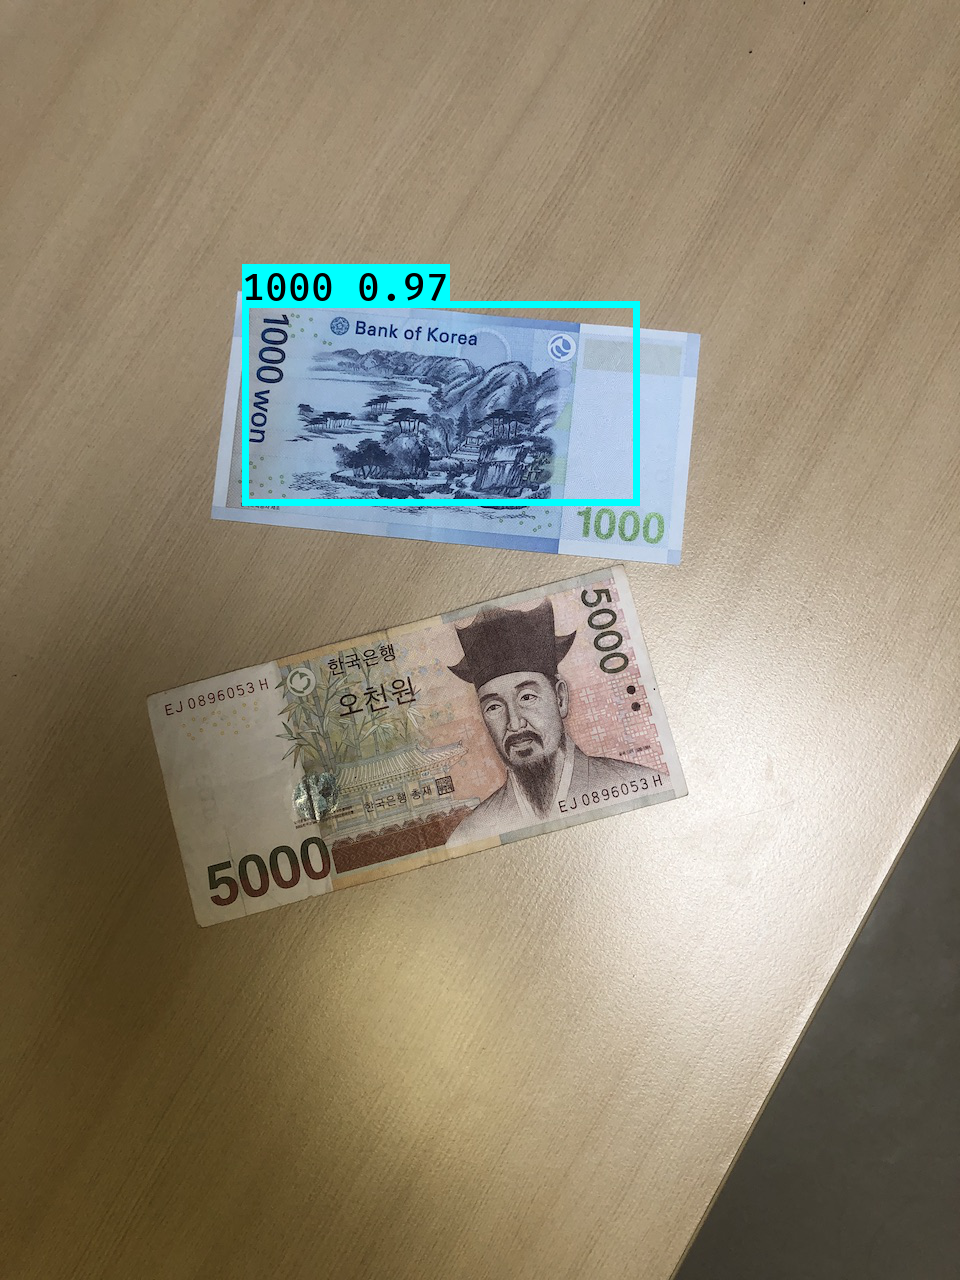

In [8]:
objectDetection('data/money/images_train/b0142.jpg', 'logs/001/trained_tiny_weights_final.h5', 'data/money/classes.txt')

In [ ]:
import tensorflow as tf

# load saved model
loaded = tf.saved_model.load('model/model/')

In [ ]:
print(list(loaded.signatures.keys()))

In [ ]:
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)